# Coursework 2 - PyTorch based experiment framework

## Intro
Welcome to the coursework 2 PyTorch experiment framework. Pytorch is a  modern, intuitive, highly Pythonic and very fast framework for building differentiable graphs. Neural networks, as it happens, are a type of acyclic differentiable graph, so PyTorch is a great framework to use, if you want to build  complicated deep networks fairly easily.

## MLP package vs Pytorch
**Student**: So, why do I have to learn to use PyTorch now? I've spent all this time working on the MLP framework. Was that a waste of time?

**TA**: Well, Pytorch is everything the MLP package is, but faster, cleaner and far more resourceful. Since it is one of the main deep learning frameworks being used by industry and research alike, it has been fine-tuned quite a bit, to conform to the expectation of researchers and engineers alike. What this means, is that PyTorch is now a very robust and highly flexible package, that you can use for any project you want to work on in the future, if it involves trainining differentiable graphs. 

In addition, MLP is written in NumPy and your time working on it has taught some low level details of NNs; PyTorch was written to look as much as possible to NumPy, so it will feel very familiar to you. The skills you have acquired are highly transferable (that is, they generalize well, so not much overfitting there...). 

PyTorch will almost always have all the latest and greatest implemented in it as soon as they are released as papers, and if not, give it a week or two and someone will reproduce it. If you can't wait, you can reproduce it yourself and open source it. A great way to show your skills and get github likes. 

In addition PyTorch has Autograd! Automatic differentiation (previously mentioned in [lectures](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp05-learn.pdf)). "What is this?" you may ask. Remember having to write all those backprop functions? Forget about it. Automatic differentiation allows you to backprop through any PyTorch operation you have used in your graph, by simply calling backward(). This [blog-post](https://jdhao.github.io/2017/11/12/pytorch-computation-graph/) explains how Pytorch's autograd works at an intuitive level.

**Student**: Why did we even have to use the MLP package? We did we even bother if such awesome frameworks are available?

**TA**: The purpose of the MLP package was not to allow you to build fast deep learning systems. Instead, it was to help teach you the low level mechanics and sensitivities of building a deep learning system. It allowed you to delve deep into how one can go about building a deep learning framework from scratch. The intuitions you have gained from going through your assignments and courseworks allow you to see deeper in what makes or breaks a deep learning system, at a level few people actually have. You are no longer restricted to the higher level modules provided by Pytorch/TensorFlow. 

If, for example, a new project required you to build something that does not exist in PyTorch/TensorFlow, or otherwise modify existing modules in a way that requires understanding and intuitions on backpropagation and layer/optimizer/component implementation, you would be able to do it much more easily than others who did not. You are now equipped to understand differentiable graphs, the chain rule, numerical errors, debugging at the lowest level and deep learning system architecture. 

In addition, by trying to implement your modules in an efficient way, you have also become aware of how to optimize a system for efficiency, and gave you intuitions on how one could further improve such a system (parallelization of implementations). 

Finally, the slowness of CPU training has allowed you to understand just how important modern GPU acceleration is, for deep learning research and applications. By coming across a large breadth of problems and understanding their origins, you will now be able to both anticipate and solve future problems in a more comprehensive way than someone who did not go through the trouble of implementing the basics from scratch. 

**Student**: If we are switching to Pytorch, then why bother implementing convolutions in the MLP package for the coursework?

**TA**: All your instructors, myself included, have found it greatly beneficial to implement convolutional networks from scratch. Once you implement convolutional layers, you will have a much deeper insight and understanding into how and why they work... as well as how they break. This way, you know what to do and what to avoid in the future. You might even be able to come with the next great network type yourself. 


## Getting Started

**Student**: So, how is the learning curve of Pytorch? How do I start?

**TA**: You can start by using this notebook on your experiments, it should teach you quite a lot on how to properly use PyTorch for basic conv net training. You should be aware of the [official pytorch github](https://github.com/pytorch/pytorch), the [pytorch official documentation page](https://pytorch.org/docs/stable/nn.html) and the [pytorch tutorials page](https://pytorch.org/tutorials/). 

Over the past year, nearly all students using PyTorch and Tensorflow on MLP and on projects found it easier and faster to get up to speed with PyTorch. In fact, I was a TensorFlow user myself, and learning TensorFlow was much more challenging than PyTorch. Mainly because TensorFlow has its own way of 'thinking' about how you build a graph and execute operations - whereas PyTorch is dynamic and works like NumPy, hence is more intuitive. If you were able to work well with the MLP package, you'll be up and running in no time. 

**Student**: OK, so how fast is pytorch compared to MLP?

**TA**: On the CPU side of things, you'll find pytorch at least 5x faster than the MLP framework (about equal for fully connected networks, but much faster for more complicated things like convolutions - unless you write extremely efficient convolutional layer code), and if you choose to use GPUs, either using MS Azure, Google Cloud or our very own MLP Cluster (available for next semester), you can expect, depending on implementation and hardware an approximate 25-70x speed ups, compared to the CPU performance of pytorch. Yes, that means an experiment that would run overnight, now would only require about 15 minutes.

**Student**: Ahh, where should I go to ask more questions?

**TA**: As always, start with a Google/DuckDuckGo search, then have a look at the PyTorch Github and PyTorch docs, and if you can't find the answer come to Piazza and the lab sessions. We will be there to support you.


#### Note: The code in this jupyter notebook is to introduce you to pytorch and allow you to play around with it in an interactive manner. However, to run your experiments, you should use the Pytorch experiment framework located in ```mlp/pytorch_experiment_scripts```. Instructions on how to use it can be found in ```notes/pytorch-experiment-framework.md``` along with the comments and documentation included in the code itself.

In [1]:
from torch import nn
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import tqdm
import os
import mlp.data_providers as data_providers
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    
    
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in total_losses.keys():
        if "acc" in k:
            ax_2.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    plt.show()

In [3]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_shape, dim_reduction_type, num_output_classes, num_filters, num_layers, use_bias=False,stride=1):
        """
        Initializes a convolutional network module object.
        :param input_shape: The shape of the inputs going in to the network.
        :param dim_reduction_type: The type of dimensionality reduction to apply after each convolutional stage, should be one of ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
        :param num_output_classes: The number of outputs the network should have (for classification those would be the number of classes)
        :param num_filters: Number of filters used in every conv layer, except dim reduction stages, where those are automatically infered.
        :param num_layers: Number of conv layers (excluding dim reduction stages)
        :param use_bias: Whether our convolutions will use a bias.
        """
        super(ConvolutionalNetwork, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.num_output_classes = num_output_classes
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.dim_reduction_type = dim_reduction_type
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        self.stride = stride
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of ConvolutionalNetwork using input shape", self.input_shape)
        x = torch.zeros((self.input_shape))  # create dummy inputs to be used to infer shapes of layers

        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        for i in range(self.num_layers):  # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                             # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=self.num_filters, padding=1,stride=self.stride,
                                                             bias=self.use_bias)

            out = self.layer_dict['conv_{}'.format(i)](out)  # use layer on inputs to get an output
            out = F.relu(out)  # apply relu
            print(out.shape)
            if self.dim_reduction_type == 'strided_convolution':  # if dim reduction is strided conv, then add a strided conv
                self.layer_dict['dim_reduction_strided_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=3,
                                                                                       dilation=1)

                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # use strided conv to get an output
                out = F.relu(out)  # apply relu to the output
            elif self.dim_reduction_type == 'dilated_convolution':  # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=3,
                                                                                       dilation=i + 2)
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](
                    out)  # run dilated conv on input to get output
                out = F.relu(out)  # apply relu on output

            elif self.dim_reduction_type == 'max_pooling':
                self.layer_dict['dim_reduction_max_pool_{}'.format(i)] = nn.MaxPool2d(3, padding=1)
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                self.layer_dict['dim_reduction_avg_pool_{}'.format(i)] = nn.AvgPool2d(3, padding=1)
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

            print(out.shape)
        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)  # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        print('shape before final linear layer', out.shape)
        out = out.view(out.shape[0], -1)
        self.logit_linear_layer = nn.Linear(in_features=out.shape[1],  # add a linear layer
                                            out_features=self.num_output_classes,
                                            bias=self.use_bias)
        out = self.logit_linear_layer(out)  # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        return out

    def forward(self, x):
        """
        Forward propages the network given an input batch
        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        out = x
        for i in range(self.num_layers):  # for number of layers

            out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
            out = F.relu(out)  # pass conv outputs through ReLU
            if self.dim_reduction_type == 'strided_convolution':  # if strided convolution dim reduction then
                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # pass previous outputs through a strided convolution indexed i
                out = F.relu(out)  # pass strided conv outputs through ReLU

            elif self.dim_reduction_type == 'dilated_convolution':
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'max_pooling':
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)
        out = out.view(out.shape[0], -1)  # flatten outputs from (b, c, h, w) to (b, c*h*w)
        out = self.logit_linear_layer(out)  # pass through a linear layer to get logits/preds
        return out

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        for item in self.layer_dict.children():
            try:
                item.reset_parameters()
            except:
                pass

        self.logit_linear_layer.reset_parameters()

In [4]:
import time
from mlp.pytorch_experiment_scripts.storage_utils import save_statistics
class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()
        if torch.cuda.is_available() and use_gpu: # checks whether a cuda gpu is available and whether the gpu flag is True
            self.device = torch.device('cuda') # sets device to be cuda
            os.environ["CUDA_VISIBLE_DEVICES"] = "0" # sets the main GPU to be the one at index 0
            print("use GPU")
        else:
            print("use CPU")
            self.device = torch.device('cpu') # sets the device to be CPU

        self.experiment_name = experiment_name
        self.model = network_model
        self.model.to(self.device) # sends the model from the cpu to the gpu
        self.model.reset_parameters() # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optim.Adam(self.parameters(), amsgrad=False,
                                    weight_decay=weight_decay_coefficient)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.
        self.totalTime = 0
        if not os.path.exists(self.experiment_folder): # If experiment directory does not exist
            os.mkdir(self.experiment_folder) # create the experiment directory
            os.mkdir(self.experiment_logs) # create the experiment log directory
            os.mkdir(self.experiment_saved_models) # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device) # send the loss computation to the GPU

        if continue_from_epoch != -1: # if continue from epoch is not -1 then
            self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch) # reload existing model from epoch and return best val model index
                                             # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.starting_epoch = 0

    def run_train_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.train() # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # send data to device as torch tensors
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(input=out, target=y) # compute loss

        self.optimizer.zero_grad() # set all weight grads from previous training iters to 0
        loss.backward() # backpropagate to compute gradients for current iter loss

        self.optimizer.step() # update network parameters
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval() # sets the system to validation mode
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(out, y) # compute loss
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.

        """
        state = dict()
        state['network'] = self.state_dict() # save network parameter and other variables.
        state['best_val_model_idx'] = best_validation_model_idx # save current best val idx
        state['best_val_model_acc'] = best_validation_model_acc # save current best val acc
        torch.save(state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx)))) # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []} # initialize a dict to keep the per-epoch metrics
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

            with tqdm.tqdm(total=self.train_data.num_batches) as pbar_train: # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data): # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y) # take a training iter step
                    current_epoch_losses["train_loss"].append(loss) # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy) # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=self.val_data.num_batches) as pbar_val: # create a progress bar for validation
                for x, y in self.val_data: # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y) # run a validation iter
                    current_epoch_losses["val_loss"].append(loss) # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy) # add current iter acc to val acc lst.
                    pbar_val.update(1) # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            if np.mean(current_epoch_losses['val_acc']) > self.best_val_model_acc: # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = np.mean(current_epoch_losses['val_acc']) # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(value)) # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv',
                            stats_dict=total_losses, current_epoch=i) # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time # calculate time taken for epoch
            self.totalTime += epoch_elapsed_time
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            seconds = self.totalTime
            m, s = divmod(seconds, 60)
            print('total time{} : {}'.format(m,s))
            self.save_model(model_save_dir=self.experiment_saved_models, # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)

        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx, # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []} # initialize a statistics dict
        with tqdm.tqdm(total=self.test_data.num_batches) as pbar_test: # ini a progress bar
            for x, y in self.test_data: # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x, y=y) # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss) # save test loss
                current_epoch_losses["test_acc"].append(accuracy) # save test accuracy
                pbar_test.update(1) # update progress bar status
                pbar_test.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output

        test_losses = {key: [np.mean(value)] for key, value in current_epoch_losses.items()} # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename='test_summary.csv', # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0)

        return total_losses, test_losses


KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd20a17a208>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd209e8f320>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd209e8f278>)
stride3_filter64_layer4_type0
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 10, 10])
torch.Size([100, 64, 10, 10])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


  0%|          | 0/1000 [00:00<?, ?it/s]

ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.6818, accuracy: 0.8400: 100%|██████████| 158/158 [00:01<00:00, 116.11it/s]


Epoch 0: train_acc_0.6609_train_loss_1.1092_val_acc_0.8160_val_loss_0.5562 epoch time 22.4877 seconds
total time0.0 : 22.48766040802002


loss: 0.3609, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.35it/s]

Epoch 1: train_acc_0.8263_train_loss_0.5053_val_acc_0.8439_val_loss_0.4547 epoch time 21.6281 seconds
total time0.0 : 44.11571741104126


loss: 0.4007, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:19, 50.03it/s]

Epoch 2: train_acc_0.8511_train_loss_0.4254_val_acc_0.8564_val_loss_0.4118 epoch time 21.8431 seconds
total time1.0 : 5.9587812423706055


loss: 0.4566, accuracy: 0.8300:   1%|          | 9/1000 [00:00<00:20, 49.54it/s]

Epoch 3: train_acc_0.8641_train_loss_0.3803_val_acc_0.8635_val_loss_0.3983 epoch time 21.6825 seconds
total time1.0 : 27.64127254486084


loss: 0.2917, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 51.43it/s]

Epoch 4: train_acc_0.8722_train_loss_0.3521_val_acc_0.8597_val_loss_0.4098 epoch time 22.1504 seconds
total time1.0 : 49.791707277297974


loss: 0.2367, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 49.96it/s]

Epoch 5: train_acc_0.8788_train_loss_0.3295_val_acc_0.8672_val_loss_0.3760 epoch time 21.6503 seconds
total time2.0 : 11.441961526870728


loss: 0.1670, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.15it/s]

Epoch 6: train_acc_0.8845_train_loss_0.3110_val_acc_0.8734_val_loss_0.3665 epoch time 21.7262 seconds
total time2.0 : 33.168139696121216


loss: 0.3076, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 50.74it/s]

Epoch 7: train_acc_0.8901_train_loss_0.2928_val_acc_0.8763_val_loss_0.3625 epoch time 21.6656 seconds
total time2.0 : 54.83376741409302


loss: 0.2332, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 51.93it/s]

Epoch 8: train_acc_0.8945_train_loss_0.2788_val_acc_0.8738_val_loss_0.3532 epoch time 21.8495 seconds
total time3.0 : 16.68323540687561


loss: 0.2404, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.77it/s]

Epoch 9: train_acc_0.8965_train_loss_0.2680_val_acc_0.8737_val_loss_0.3712 epoch time 21.7092 seconds
total time3.0 : 38.392457246780396


loss: 0.2166, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.52it/s]

Epoch 10: train_acc_0.8998_train_loss_0.2558_val_acc_0.8744_val_loss_0.3824 epoch time 21.9076 seconds
total time4.0 : 0.30003857612609863


loss: 0.2115, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 49.34it/s]

Epoch 11: train_acc_0.9042_train_loss_0.2443_val_acc_0.8749_val_loss_0.3713 epoch time 21.6256 seconds
total time4.0 : 21.92566728591919


loss: 0.2379, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 50.77it/s]

Epoch 12: train_acc_0.9068_train_loss_0.2343_val_acc_0.8794_val_loss_0.3689 epoch time 21.9268 seconds
total time4.0 : 43.85246682167053


loss: 0.2500, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.24it/s]

Epoch 13: train_acc_0.9102_train_loss_0.2259_val_acc_0.8796_val_loss_0.3768 epoch time 21.6964 seconds
total time5.0 : 5.548861980438232


loss: 0.2251, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 50.22it/s]

Epoch 14: train_acc_0.9123_train_loss_0.2202_val_acc_0.8780_val_loss_0.3975 epoch time 22.0960 seconds
total time5.0 : 27.644853353500366


loss: 0.1207, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.63it/s]

Epoch 15: train_acc_0.9150_train_loss_0.2131_val_acc_0.8787_val_loss_0.3925 epoch time 21.7245 seconds
total time5.0 : 49.36933422088623


loss: 0.1580, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.12it/s]

Epoch 16: train_acc_0.9159_train_loss_0.2088_val_acc_0.8782_val_loss_0.4008 epoch time 21.6380 seconds
total time6.0 : 11.007314205169678


loss: 0.2125, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 51.28it/s]

Epoch 17: train_acc_0.9186_train_loss_0.2011_val_acc_0.8706_val_loss_0.4129 epoch time 21.6477 seconds
total time6.0 : 32.65497136116028


loss: 0.1550, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 49.85it/s]

Epoch 18: train_acc_0.9202_train_loss_0.1943_val_acc_0.8765_val_loss_0.4179 epoch time 21.8218 seconds
total time6.0 : 54.47677969932556


loss: 0.1365, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.23it/s]

Epoch 19: train_acc_0.9210_train_loss_0.1928_val_acc_0.8766_val_loss_0.4129 epoch time 22.0536 seconds
total time7.0 : 16.530420064926147


loss: 0.2470, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:19, 51.70it/s]

Epoch 20: train_acc_0.9234_train_loss_0.1842_val_acc_0.8785_val_loss_0.4374 epoch time 22.0327 seconds
total time7.0 : 38.56316375732422


loss: 0.1842, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 48.94it/s]

Epoch 21: train_acc_0.9251_train_loss_0.1812_val_acc_0.8780_val_loss_0.4349 epoch time 21.4536 seconds
total time8.0 : 0.016736984252929688


loss: 0.1333, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.20it/s]

Epoch 22: train_acc_0.9270_train_loss_0.1756_val_acc_0.8753_val_loss_0.4332 epoch time 21.9753 seconds
total time8.0 : 21.992007970809937


loss: 0.1421, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.70it/s]

Epoch 23: train_acc_0.9282_train_loss_0.1745_val_acc_0.8756_val_loss_0.4643 epoch time 21.7918 seconds
total time8.0 : 43.78376507759094


loss: 0.1487, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.49it/s]

Epoch 24: train_acc_0.9284_train_loss_0.1714_val_acc_0.8724_val_loss_0.4869 epoch time 21.9140 seconds
total time9.0 : 5.697785377502441


loss: 0.0538, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.88it/s]

Epoch 25: train_acc_0.9309_train_loss_0.1652_val_acc_0.8711_val_loss_0.4863 epoch time 21.6919 seconds
total time9.0 : 27.389718294143677


loss: 0.0659, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.74it/s]

Epoch 26: train_acc_0.9316_train_loss_0.1632_val_acc_0.8753_val_loss_0.5002 epoch time 21.8538 seconds
total time9.0 : 49.24355173110962


loss: 0.2019, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.52it/s]

Epoch 27: train_acc_0.9336_train_loss_0.1614_val_acc_0.8696_val_loss_0.5130 epoch time 21.7229 seconds
total time10.0 : 10.966437101364136


loss: 0.1255, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 49.42it/s]

Epoch 28: train_acc_0.9351_train_loss_0.1574_val_acc_0.8728_val_loss_0.5108 epoch time 22.0032 seconds
total time10.0 : 32.96964359283447


loss: 0.1568, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 52.11it/s]

Epoch 29: train_acc_0.9348_train_loss_0.1563_val_acc_0.8709_val_loss_0.5168 epoch time 21.7476 seconds
total time10.0 : 54.71726894378662


loss: 0.2702, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.63it/s]

Epoch 30: train_acc_0.9381_train_loss_0.1501_val_acc_0.8756_val_loss_0.5030 epoch time 21.8262 seconds
total time11.0 : 16.543437719345093


loss: 0.2268, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.27it/s]

Epoch 31: train_acc_0.9382_train_loss_0.1468_val_acc_0.8706_val_loss_0.5182 epoch time 21.7449 seconds
total time11.0 : 38.28835701942444


loss: 0.0916, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:18, 52.25it/s]

Epoch 32: train_acc_0.9390_train_loss_0.1458_val_acc_0.8727_val_loss_0.5187 epoch time 21.9595 seconds
total time12.0 : 0.24783945083618164


loss: 0.1323, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 49.75it/s]

Epoch 33: train_acc_0.9396_train_loss_0.1469_val_acc_0.8684_val_loss_0.5280 epoch time 21.6848 seconds
total time12.0 : 21.932610273361206


loss: 0.0672, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 51.43it/s]

Epoch 34: train_acc_0.9414_train_loss_0.1433_val_acc_0.8695_val_loss_0.5507 epoch time 22.1451 seconds
total time12.0 : 44.07774376869202


loss: 0.1011, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 50.82it/s]

Epoch 35: train_acc_0.9430_train_loss_0.1373_val_acc_0.8746_val_loss_0.5453 epoch time 21.4426 seconds
total time13.0 : 5.520301818847656


loss: 0.1699, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.37it/s]

Epoch 36: train_acc_0.9439_train_loss_0.1353_val_acc_0.8707_val_loss_0.5357 epoch time 21.9898 seconds
total time13.0 : 27.5101215839386


loss: 0.0761, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.91it/s]

Epoch 37: train_acc_0.9448_train_loss_0.1359_val_acc_0.8741_val_loss_0.5606 epoch time 21.7286 seconds
total time13.0 : 49.23867678642273


loss: 0.0986, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.63it/s]

Epoch 38: train_acc_0.9453_train_loss_0.1330_val_acc_0.8729_val_loss_0.5691 epoch time 22.0234 seconds
total time14.0 : 11.262080907821655


loss: 0.0591, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.55it/s]

Epoch 39: train_acc_0.9466_train_loss_0.1281_val_acc_0.8696_val_loss_0.6189 epoch time 21.8173 seconds
total time14.0 : 33.07933259010315


loss: 0.1684, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.08it/s]

Epoch 40: train_acc_0.9460_train_loss_0.1309_val_acc_0.8703_val_loss_0.5642 epoch time 22.1350 seconds
total time14.0 : 55.21428442001343


loss: 0.1149, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 48.93it/s]

Epoch 41: train_acc_0.9470_train_loss_0.1286_val_acc_0.8680_val_loss_0.6277 epoch time 21.7478 seconds
total time15.0 : 16.962098836898804


loss: 0.1002, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.44it/s]

Epoch 42: train_acc_0.9477_train_loss_0.1279_val_acc_0.8709_val_loss_0.5589 epoch time 21.9979 seconds
total time15.0 : 38.959954023361206


loss: 0.1549, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.73it/s]

Epoch 43: train_acc_0.9494_train_loss_0.1232_val_acc_0.8703_val_loss_0.5741 epoch time 21.8311 seconds
total time16.0 : 0.7910621166229248


loss: 0.0497, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.41it/s]

Epoch 44: train_acc_0.9519_train_loss_0.1171_val_acc_0.8700_val_loss_0.5658 epoch time 21.8461 seconds
total time16.0 : 22.63718819618225


loss: 0.1070, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 49.44it/s]

Epoch 45: train_acc_0.9516_train_loss_0.1187_val_acc_0.8691_val_loss_0.6537 epoch time 21.6951 seconds
total time16.0 : 44.33228063583374


loss: 0.1094, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 49.81it/s]

Epoch 46: train_acc_0.9502_train_loss_0.1221_val_acc_0.8683_val_loss_0.6081 epoch time 22.0717 seconds
total time17.0 : 6.403943300247192


loss: 0.0834, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.80it/s]

Epoch 47: train_acc_0.9531_train_loss_0.1154_val_acc_0.8669_val_loss_0.6909 epoch time 21.6618 seconds
total time17.0 : 28.06578302383423


loss: 0.1074, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.40it/s]

Epoch 48: train_acc_0.9528_train_loss_0.1169_val_acc_0.8647_val_loss_0.6431 epoch time 21.7962 seconds
total time17.0 : 49.86196041107178


loss: 0.0781, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.72it/s]

Epoch 49: train_acc_0.9545_train_loss_0.1130_val_acc_0.8665_val_loss_0.6480 epoch time 21.4918 seconds
total time18.0 : 11.353780269622803


loss: 0.1288, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.63it/s]

Epoch 50: train_acc_0.9545_train_loss_0.1131_val_acc_0.8641_val_loss_0.6748 epoch time 22.0039 seconds
total time18.0 : 33.357672691345215


loss: 0.0699, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.58it/s]

Epoch 51: train_acc_0.9543_train_loss_0.1137_val_acc_0.8655_val_loss_0.6304 epoch time 21.7842 seconds
total time18.0 : 55.14187574386597


loss: 0.1099, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.63it/s]

Epoch 52: train_acc_0.9556_train_loss_0.1097_val_acc_0.8674_val_loss_0.6683 epoch time 22.0675 seconds
total time19.0 : 17.209378480911255


loss: 0.0777, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.06it/s]

Epoch 53: train_acc_0.9558_train_loss_0.1103_val_acc_0.8659_val_loss_0.6570 epoch time 21.6301 seconds
total time19.0 : 38.8394341468811


loss: 0.0578, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.16it/s]

Epoch 54: train_acc_0.9576_train_loss_0.1047_val_acc_0.8655_val_loss_0.6988 epoch time 21.9792 seconds
total time20.0 : 0.8186123371124268


loss: 0.0760, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.98it/s]

Epoch 55: train_acc_0.9563_train_loss_0.1088_val_acc_0.8694_val_loss_0.6889 epoch time 21.8667 seconds
total time20.0 : 22.68528938293457


loss: 0.0800, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.89it/s]

Epoch 56: train_acc_0.9585_train_loss_0.1041_val_acc_0.8627_val_loss_0.7270 epoch time 22.2658 seconds
total time20.0 : 44.951120376586914


loss: 0.1136, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 49.08it/s]

Epoch 57: train_acc_0.9568_train_loss_0.1076_val_acc_0.8672_val_loss_0.7089 epoch time 21.7228 seconds
total time21.0 : 6.67387056350708


loss: 0.1246, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.93it/s]

Epoch 58: train_acc_0.9594_train_loss_0.1013_val_acc_0.8654_val_loss_0.7220 epoch time 22.1472 seconds
total time21.0 : 28.82106637954712


loss: 0.1429, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.63it/s]

Epoch 59: train_acc_0.9576_train_loss_0.1066_val_acc_0.8654_val_loss_0.6956 epoch time 21.9720 seconds
total time21.0 : 50.79310846328735


loss: 0.0542, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 49.56it/s]

Epoch 60: train_acc_0.9602_train_loss_0.0994_val_acc_0.8666_val_loss_0.7217 epoch time 22.4567 seconds
total time22.0 : 13.249778270721436


loss: 0.0669, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.84it/s]

Epoch 61: train_acc_0.9594_train_loss_0.1039_val_acc_0.8676_val_loss_0.6805 epoch time 21.8846 seconds
total time22.0 : 35.13433861732483


loss: 0.1646, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.30it/s]

Epoch 62: train_acc_0.9595_train_loss_0.1027_val_acc_0.8656_val_loss_0.7458 epoch time 22.2262 seconds
total time22.0 : 57.360519886016846


loss: 0.0913, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 49.51it/s]

Epoch 63: train_acc_0.9614_train_loss_0.0950_val_acc_0.8675_val_loss_0.7606 epoch time 21.4351 seconds
total time23.0 : 18.795615196228027


loss: 0.1309, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.67it/s]

Epoch 64: train_acc_0.9617_train_loss_0.0960_val_acc_0.8621_val_loss_0.7285 epoch time 22.1308 seconds
total time23.0 : 40.92640256881714


loss: 0.2077, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.93it/s]

Epoch 65: train_acc_0.9607_train_loss_0.1007_val_acc_0.8659_val_loss_0.6994 epoch time 21.7999 seconds
total time24.0 : 2.726266860961914


loss: 0.1080, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 49.03it/s]

Epoch 66: train_acc_0.9630_train_loss_0.0945_val_acc_0.8666_val_loss_0.7427 epoch time 22.2206 seconds
total time24.0 : 24.94687819480896


loss: 0.0851, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.73it/s]

Epoch 67: train_acc_0.9610_train_loss_0.0992_val_acc_0.8672_val_loss_0.7380 epoch time 22.0121 seconds
total time24.0 : 46.95896244049072


loss: 0.0490, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.78it/s]

Epoch 68: train_acc_0.9629_train_loss_0.0936_val_acc_0.8673_val_loss_0.7453 epoch time 22.5354 seconds
total time25.0 : 9.494388580322266


loss: 0.1535, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.24it/s]

Epoch 69: train_acc_0.9630_train_loss_0.0944_val_acc_0.8659_val_loss_0.7174 epoch time 21.9200 seconds
total time25.0 : 31.414401531219482


loss: 0.0482, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.42it/s]

Epoch 70: train_acc_0.9642_train_loss_0.0917_val_acc_0.8682_val_loss_0.7641 epoch time 22.1827 seconds
total time25.0 : 53.597126483917236


loss: 0.0590, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.38it/s]

Epoch 71: train_acc_0.9628_train_loss_0.0946_val_acc_0.8666_val_loss_0.8052 epoch time 21.8922 seconds
total time26.0 : 15.489286184310913


loss: 0.1013, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.59it/s]

Epoch 72: train_acc_0.9638_train_loss_0.0923_val_acc_0.8658_val_loss_0.7570 epoch time 22.0403 seconds
total time26.0 : 37.52958011627197


loss: 0.0464, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 51.70it/s]

Epoch 73: train_acc_0.9640_train_loss_0.0917_val_acc_0.8651_val_loss_0.7181 epoch time 21.7850 seconds
total time26.0 : 59.31461954116821


loss: 0.1077, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.23it/s]

Epoch 74: train_acc_0.9663_train_loss_0.0865_val_acc_0.8651_val_loss_0.8020 epoch time 21.8040 seconds
total time27.0 : 21.118627548217773


loss: 0.1145, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.82it/s]

Epoch 75: train_acc_0.9649_train_loss_0.0921_val_acc_0.8678_val_loss_0.7347 epoch time 21.6556 seconds
total time27.0 : 42.774179220199585


loss: 0.1297, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.66it/s]

Epoch 76: train_acc_0.9659_train_loss_0.0881_val_acc_0.8655_val_loss_0.8143 epoch time 22.0506 seconds
total time28.0 : 4.8248069286346436


loss: 0.3203, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.40it/s]

Epoch 77: train_acc_0.9660_train_loss_0.0874_val_acc_0.8635_val_loss_0.7911 epoch time 21.5515 seconds
total time28.0 : 26.376299619674683


loss: 0.0626, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.88it/s]

Epoch 78: train_acc_0.9664_train_loss_0.0881_val_acc_0.8639_val_loss_0.8618 epoch time 21.9778 seconds
total time28.0 : 48.35412859916687


loss: 0.0811, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 49.14it/s]

Epoch 79: train_acc_0.9648_train_loss_0.0917_val_acc_0.8631_val_loss_0.9007 epoch time 21.7581 seconds
total time29.0 : 10.11220407485962


loss: 0.0705, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.28it/s]

Epoch 80: train_acc_0.9676_train_loss_0.0838_val_acc_0.8680_val_loss_0.9224 epoch time 22.1546 seconds
total time29.0 : 32.2668354511261


loss: 0.1510, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.19it/s]

Epoch 81: train_acc_0.9673_train_loss_0.0843_val_acc_0.8628_val_loss_0.7889 epoch time 21.8373 seconds
total time29.0 : 54.104185342788696


loss: 0.0745, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.56it/s]

Epoch 82: train_acc_0.9676_train_loss_0.0827_val_acc_0.8641_val_loss_0.8467 epoch time 22.3248 seconds
total time30.0 : 16.428993701934814


loss: 0.0582, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 49.17it/s]

Epoch 83: train_acc_0.9666_train_loss_0.0872_val_acc_0.8651_val_loss_0.8527 epoch time 22.0365 seconds
total time30.0 : 38.46549105644226


loss: 0.0250, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.26it/s]

Epoch 84: train_acc_0.9679_train_loss_0.0838_val_acc_0.8633_val_loss_0.7996 epoch time 22.3200 seconds
total time31.0 : 0.7854533195495605


loss: 0.0279, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 51.63it/s]

Epoch 85: train_acc_0.9690_train_loss_0.0817_val_acc_0.8615_val_loss_0.8768 epoch time 22.1524 seconds
total time31.0 : 22.937869787216187


loss: 0.0691, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.28it/s]

Epoch 86: train_acc_0.9697_train_loss_0.0788_val_acc_0.8608_val_loss_0.8629 epoch time 22.1403 seconds
total time31.0 : 45.078136682510376


loss: 0.0691, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.82it/s]

Epoch 87: train_acc_0.9680_train_loss_0.0851_val_acc_0.8653_val_loss_0.8345 epoch time 21.9250 seconds
total time32.0 : 7.003112554550171


loss: 0.0762, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.51it/s]

Epoch 88: train_acc_0.9686_train_loss_0.0837_val_acc_0.8667_val_loss_0.8040 epoch time 22.3572 seconds
total time32.0 : 29.36028289794922


loss: 0.2251, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 49.32it/s]

Epoch 89: train_acc_0.9711_train_loss_0.0761_val_acc_0.8646_val_loss_0.9384 epoch time 22.1053 seconds
total time32.0 : 51.46555042266846


loss: 0.0331, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:19, 50.65it/s]

Epoch 90: train_acc_0.9696_train_loss_0.0806_val_acc_0.8662_val_loss_0.8747 epoch time 22.5545 seconds
total time33.0 : 14.020052671432495


loss: 0.0599, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.97it/s]

Epoch 91: train_acc_0.9704_train_loss_0.0775_val_acc_0.8616_val_loss_0.9022 epoch time 21.6280 seconds
total time33.0 : 35.648077726364136


loss: 0.0418, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.73it/s]

Epoch 92: train_acc_0.9698_train_loss_0.0801_val_acc_0.8661_val_loss_0.8711 epoch time 22.2007 seconds
total time33.0 : 57.84874939918518


loss: 0.0440, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.32it/s]

Epoch 93: train_acc_0.9710_train_loss_0.0775_val_acc_0.8671_val_loss_0.8958 epoch time 21.9553 seconds
total time34.0 : 19.80409049987793


loss: 0.0173, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 49.44it/s]

Epoch 94: train_acc_0.9712_train_loss_0.0781_val_acc_0.8676_val_loss_0.8667 epoch time 22.4034 seconds
total time34.0 : 42.20751428604126


loss: 0.0665, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.98it/s]

Epoch 95: train_acc_0.9719_train_loss_0.0755_val_acc_0.8660_val_loss_0.8655 epoch time 21.9592 seconds
total time35.0 : 4.166668176651001


loss: 0.0971, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 49.49it/s]

Epoch 96: train_acc_0.9719_train_loss_0.0770_val_acc_0.8629_val_loss_0.8889 epoch time 22.6642 seconds
total time35.0 : 26.83088254928589


loss: 0.0404, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.86it/s]

Epoch 97: train_acc_0.9716_train_loss_0.0767_val_acc_0.8636_val_loss_0.8828 epoch time 22.0494 seconds
total time35.0 : 48.88026142120361


loss: 0.0647, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.21it/s]

Epoch 98: train_acc_0.9728_train_loss_0.0745_val_acc_0.8624_val_loss_0.8802 epoch time 22.5321 seconds
total time36.0 : 11.412357568740845


loss: 0.2364, accuracy: 0.9100:  15%|█▍        | 23/158 [00:00<00:01, 133.90it/s]

Epoch 99: train_acc_0.9716_train_loss_0.0764_val_acc_0.8604_val_loss_0.8700 epoch time 21.7898 seconds
total time36.0 : 33.202181816101074
Generating test set evaluation metrics


loss: 0.6326, accuracy: 0.7900: 100%|██████████| 158/158 [00:01<00:00, 110.13it/s]


finish


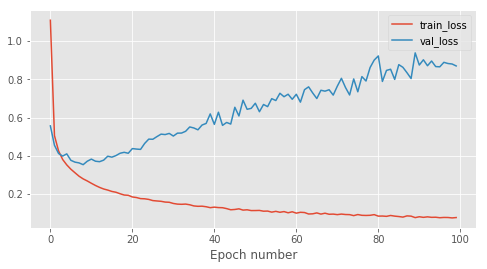

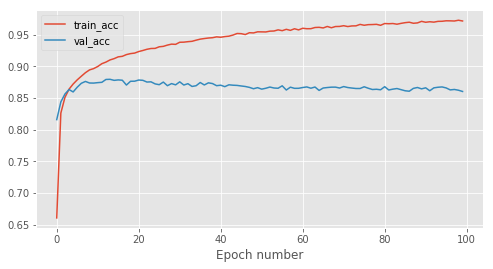

stride3_filter64_layer4_type1
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 9, 9])
torch.Size([100, 64, 9, 9])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])


RuntimeError: Given input size per channel: (2 x 2). Calculated output size per channel: (0 x 0). Output size is too small at /opt/conda/conda-bld/pytorch_1532582123400/work/aten/src/THNN/generic/SpatialDilatedConvolution.c:52

In [5]:
#stride3_filter64_layer4_type01234

batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [0,1,2,3]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [4,4,4,4]
experiment_name = []
for layer,index in zip(num_layers,dim_reduction_idx):
    experiment_name.append("stride3_filter64_layer{}_type{}".format(layer,index))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for experiment,layer,index in zip(experiment_name,num_layers,dim_reduction_idx):
    
    print(experiment)
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[index],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd209e61278>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd203eb9c88>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd203eb9d30>)
stride3_filter64_layer4_type2
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 10, 10])
torch.Size([100, 64, 10, 10])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


loss: 3.8553, accuracy: 0.0300:   1%|          | 8/1000 [00:00<00:27, 36.67it/s]

ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_3): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.3891, accuracy: 0.8600:   1%|          | 12/1000 [00:00<00:14, 66.28it/s]

Epoch 0: train_acc_0.6902_train_loss_1.0090_val_acc_0.8294_val_loss_0.5063 epoch time 17.4290 seconds
total time0.0 : 17.429039001464844


loss: 0.5287, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:14, 67.08it/s]

Epoch 1: train_acc_0.8302_train_loss_0.4926_val_acc_0.8417_val_loss_0.4553 epoch time 17.1974 seconds
total time0.0 : 34.62645244598389


loss: 0.4098, accuracy: 0.8700:   1%|▏         | 13/1000 [00:00<00:14, 68.91it/s]

Epoch 2: train_acc_0.8524_train_loss_0.4222_val_acc_0.8587_val_loss_0.3999 epoch time 16.8308 seconds
total time0.0 : 51.457247257232666


loss: 0.2722, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:14, 67.68it/s]

Epoch 3: train_acc_0.8633_train_loss_0.3844_val_acc_0.8656_val_loss_0.3742 epoch time 16.8997 seconds
total time1.0 : 8.356975555419922


loss: 0.3515, accuracy: 0.8600:   1%|          | 12/1000 [00:00<00:14, 66.28it/s]

Epoch 4: train_acc_0.8708_train_loss_0.3583_val_acc_0.8757_val_loss_0.3541 epoch time 17.2772 seconds
total time1.0 : 25.634153604507446


loss: 0.4496, accuracy: 0.8400:   1%|          | 12/1000 [00:00<00:14, 67.04it/s]

Epoch 5: train_acc_0.8763_train_loss_0.3398_val_acc_0.8757_val_loss_0.3475 epoch time 17.3142 seconds
total time1.0 : 42.9483106136322


loss: 0.1264, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 67.06it/s]

Epoch 6: train_acc_0.8804_train_loss_0.3237_val_acc_0.8784_val_loss_0.3390 epoch time 17.0872 seconds
total time2.0 : 0.03553318977355957


loss: 0.2635, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 64.50it/s]

Epoch 7: train_acc_0.8839_train_loss_0.3120_val_acc_0.8798_val_loss_0.3407 epoch time 17.1357 seconds
total time2.0 : 17.17125105857849


loss: 0.3081, accuracy: 0.8500:   1%|          | 12/1000 [00:00<00:14, 66.92it/s]

Epoch 8: train_acc_0.8876_train_loss_0.2999_val_acc_0.8784_val_loss_0.3435 epoch time 17.0343 seconds
total time2.0 : 34.20558190345764


loss: 0.1427, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:15, 65.61it/s]

Epoch 9: train_acc_0.8908_train_loss_0.2865_val_acc_0.8768_val_loss_0.3509 epoch time 17.1398 seconds
total time2.0 : 51.345332622528076


loss: 0.2617, accuracy: 0.8700:   1%|          | 12/1000 [00:00<00:14, 66.69it/s]

Epoch 10: train_acc_0.8937_train_loss_0.2771_val_acc_0.8827_val_loss_0.3397 epoch time 17.1234 seconds
total time3.0 : 8.468716144561768


loss: 0.2061, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 65.96it/s]

Epoch 11: train_acc_0.8957_train_loss_0.2683_val_acc_0.8813_val_loss_0.3402 epoch time 17.2162 seconds
total time3.0 : 25.684938669204712


loss: 0.2917, accuracy: 0.8800:   1%|▏         | 13/1000 [00:00<00:14, 69.12it/s]

Epoch 12: train_acc_0.9005_train_loss_0.2590_val_acc_0.8811_val_loss_0.3441 epoch time 16.9573 seconds
total time3.0 : 42.64220714569092


loss: 0.2980, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:14, 66.10it/s]

Epoch 13: train_acc_0.9018_train_loss_0.2515_val_acc_0.8812_val_loss_0.3494 epoch time 17.1937 seconds
total time3.0 : 59.83593821525574


loss: 0.1324, accuracy: 0.9500:   1%|          | 12/1000 [00:00<00:15, 64.08it/s]

Epoch 14: train_acc_0.9044_train_loss_0.2446_val_acc_0.8787_val_loss_0.3566 epoch time 17.3053 seconds
total time4.0 : 17.141282081604004


loss: 0.1419, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 65.25it/s]

Epoch 15: train_acc_0.9065_train_loss_0.2365_val_acc_0.8801_val_loss_0.3503 epoch time 17.3148 seconds
total time4.0 : 34.45608401298523


loss: 0.1828, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:15, 65.32it/s]

Epoch 16: train_acc_0.9084_train_loss_0.2301_val_acc_0.8808_val_loss_0.3597 epoch time 17.4208 seconds
total time4.0 : 51.876912355422974


loss: 0.2003, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:15, 64.04it/s]

Epoch 17: train_acc_0.9112_train_loss_0.2229_val_acc_0.8777_val_loss_0.3588 epoch time 17.1683 seconds
total time5.0 : 9.045202732086182


loss: 0.2532, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 66.72it/s]

Epoch 18: train_acc_0.9124_train_loss_0.2166_val_acc_0.8810_val_loss_0.3608 epoch time 17.2063 seconds
total time5.0 : 26.251477241516113


loss: 0.2946, accuracy: 0.8700:   1%|          | 12/1000 [00:00<00:14, 66.07it/s]

Epoch 19: train_acc_0.9148_train_loss_0.2105_val_acc_0.8753_val_loss_0.3770 epoch time 17.2613 seconds
total time5.0 : 43.5128231048584


loss: 0.2052, accuracy: 0.9300:   1%|▏         | 13/1000 [00:00<00:14, 68.19it/s]

Epoch 20: train_acc_0.9164_train_loss_0.2077_val_acc_0.8765_val_loss_0.3803 epoch time 17.0545 seconds
total time6.0 : 0.5673263072967529


loss: 0.0797, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 66.17it/s]

Epoch 21: train_acc_0.9187_train_loss_0.2000_val_acc_0.8826_val_loss_0.3922 epoch time 16.8456 seconds
total time6.0 : 17.41293978691101


loss: 0.1684, accuracy: 0.9500:   1%|          | 12/1000 [00:00<00:15, 65.53it/s]

Epoch 22: train_acc_0.9202_train_loss_0.1963_val_acc_0.8807_val_loss_0.3823 epoch time 17.1320 seconds
total time6.0 : 34.5449001789093


loss: 0.1880, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 66.93it/s]

Epoch 23: train_acc_0.9215_train_loss_0.1923_val_acc_0.8765_val_loss_0.3998 epoch time 17.2810 seconds
total time6.0 : 51.82589340209961


loss: 0.2975, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:15, 64.56it/s]

Epoch 24: train_acc_0.9237_train_loss_0.1858_val_acc_0.8777_val_loss_0.4266 epoch time 17.2389 seconds
total time7.0 : 9.064819097518921


loss: 0.2159, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:15, 65.72it/s]

Epoch 25: train_acc_0.9248_train_loss_0.1824_val_acc_0.8776_val_loss_0.4182 epoch time 17.2689 seconds
total time7.0 : 26.333685874938965


loss: 0.2082, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 64.56it/s]

Epoch 26: train_acc_0.9258_train_loss_0.1786_val_acc_0.8741_val_loss_0.4317 epoch time 17.2344 seconds
total time7.0 : 43.56805109977722


loss: 0.0844, accuracy: 0.9900:   1%|          | 12/1000 [00:00<00:14, 66.58it/s]

Epoch 27: train_acc_0.9266_train_loss_0.1757_val_acc_0.8751_val_loss_0.4277 epoch time 17.0926 seconds
total time8.0 : 0.6606945991516113


loss: 0.1602, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:15, 65.74it/s]

Epoch 28: train_acc_0.9289_train_loss_0.1711_val_acc_0.8685_val_loss_0.4821 epoch time 17.0878 seconds
total time8.0 : 17.748480081558228


loss: 0.0825, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 63.42it/s]

Epoch 29: train_acc_0.9298_train_loss_0.1689_val_acc_0.8758_val_loss_0.4569 epoch time 16.9907 seconds
total time8.0 : 34.73915481567383


loss: 0.3324, accuracy: 0.8600:   1%|          | 12/1000 [00:00<00:14, 66.11it/s]

Epoch 30: train_acc_0.9311_train_loss_0.1636_val_acc_0.8708_val_loss_0.4911 epoch time 16.9479 seconds
total time8.0 : 51.68705725669861


loss: 0.1513, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:14, 67.02it/s]

Epoch 31: train_acc_0.9332_train_loss_0.1608_val_acc_0.8697_val_loss_0.4725 epoch time 17.2054 seconds
total time9.0 : 8.892426490783691


loss: 0.1783, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:15, 64.81it/s]

Epoch 32: train_acc_0.9356_train_loss_0.1548_val_acc_0.8741_val_loss_0.4793 epoch time 17.2756 seconds
total time9.0 : 26.167991399765015


loss: 0.1073, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 65.75it/s]

Epoch 33: train_acc_0.9352_train_loss_0.1548_val_acc_0.8723_val_loss_0.4715 epoch time 17.3762 seconds
total time9.0 : 43.544193267822266


loss: 0.1755, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:15, 64.86it/s]

Epoch 34: train_acc_0.9352_train_loss_0.1547_val_acc_0.8701_val_loss_0.5080 epoch time 17.2225 seconds
total time10.0 : 0.7666938304901123


loss: 0.2174, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 67.11it/s]

Epoch 35: train_acc_0.9384_train_loss_0.1476_val_acc_0.8704_val_loss_0.5359 epoch time 17.2446 seconds
total time10.0 : 18.011255025863647


loss: 0.1692, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:15, 65.51it/s]

Epoch 36: train_acc_0.9383_train_loss_0.1469_val_acc_0.8664_val_loss_0.5445 epoch time 17.2849 seconds
total time10.0 : 35.29619383811951


loss: 0.1575, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:15, 65.65it/s]

Epoch 37: train_acc_0.9400_train_loss_0.1440_val_acc_0.8674_val_loss_0.5541 epoch time 17.2432 seconds
total time10.0 : 52.53941011428833


loss: 0.1215, accuracy: 0.9500:   1%|▏         | 13/1000 [00:00<00:14, 68.84it/s]

Epoch 38: train_acc_0.9404_train_loss_0.1437_val_acc_0.8720_val_loss_0.5606 epoch time 17.3365 seconds
total time11.0 : 9.87586236000061


loss: 0.1475, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:14, 66.33it/s]

Epoch 39: train_acc_0.9420_train_loss_0.1374_val_acc_0.8694_val_loss_0.5410 epoch time 16.8789 seconds
total time11.0 : 26.754750967025757


loss: 0.0872, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:15, 64.75it/s]

Epoch 40: train_acc_0.9411_train_loss_0.1403_val_acc_0.8658_val_loss_0.5319 epoch time 17.4215 seconds
total time11.0 : 44.176291942596436


loss: 0.1187, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:14, 67.21it/s]

Epoch 41: train_acc_0.9425_train_loss_0.1354_val_acc_0.8721_val_loss_0.5548 epoch time 17.2774 seconds
total time12.0 : 1.4537293910980225


loss: 0.1530, accuracy: 0.9500:   1%|          | 12/1000 [00:00<00:15, 65.01it/s]

Epoch 42: train_acc_0.9444_train_loss_0.1321_val_acc_0.8728_val_loss_0.5734 epoch time 17.1963 seconds
total time12.0 : 18.650009632110596


loss: 0.1483, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:14, 66.26it/s]

Epoch 43: train_acc_0.9465_train_loss_0.1289_val_acc_0.8649_val_loss_0.5647 epoch time 17.2282 seconds
total time12.0 : 35.87820911407471


loss: 0.1676, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:14, 66.42it/s]

Epoch 44: train_acc_0.9448_train_loss_0.1306_val_acc_0.8724_val_loss_0.5700 epoch time 17.0907 seconds
total time12.0 : 52.96887707710266


loss: 0.1100, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:14, 66.14it/s]

Epoch 45: train_acc_0.9474_train_loss_0.1247_val_acc_0.8656_val_loss_0.6257 epoch time 17.1527 seconds
total time13.0 : 10.121603965759277


loss: 0.1804, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:15, 64.77it/s]

Epoch 46: train_acc_0.9484_train_loss_0.1247_val_acc_0.8641_val_loss_0.6272 epoch time 17.2381 seconds
total time13.0 : 27.35966968536377


loss: 0.1188, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 64.52it/s]

Epoch 47: train_acc_0.9478_train_loss_0.1238_val_acc_0.8668_val_loss_0.6411 epoch time 17.2436 seconds
total time13.0 : 44.60330581665039


loss: 0.2030, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:15, 65.52it/s]

Epoch 48: train_acc_0.9499_train_loss_0.1218_val_acc_0.8651_val_loss_0.6511 epoch time 16.9457 seconds
total time14.0 : 1.54905366897583


loss: 0.1457, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:15, 64.65it/s]

Epoch 49: train_acc_0.9497_train_loss_0.1206_val_acc_0.8641_val_loss_0.6555 epoch time 17.2222 seconds
total time14.0 : 18.771219491958618


loss: 0.1395, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:15, 64.02it/s]

Epoch 50: train_acc_0.9495_train_loss_0.1209_val_acc_0.8658_val_loss_0.6813 epoch time 17.2402 seconds
total time14.0 : 36.01146125793457


loss: 0.0649, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 66.04it/s]

Epoch 51: train_acc_0.9516_train_loss_0.1163_val_acc_0.8609_val_loss_0.6697 epoch time 17.0833 seconds
total time14.0 : 53.09477496147156


loss: 0.0413, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:14, 67.69it/s]

Epoch 52: train_acc_0.9534_train_loss_0.1133_val_acc_0.8693_val_loss_0.6982 epoch time 17.1008 seconds
total time15.0 : 10.19556713104248


loss: 0.0646, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:14, 68.77it/s]

Epoch 53: train_acc_0.9519_train_loss_0.1161_val_acc_0.8615_val_loss_0.6837 epoch time 17.2528 seconds
total time15.0 : 27.448403358459473


loss: 0.0638, accuracy: 0.9900:   1%|          | 12/1000 [00:00<00:15, 64.30it/s]

Epoch 54: train_acc_0.9526_train_loss_0.1159_val_acc_0.8621_val_loss_0.7428 epoch time 17.1318 seconds
total time15.0 : 44.58018970489502


loss: 0.2191, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 65.91it/s]

Epoch 55: train_acc_0.9525_train_loss_0.1148_val_acc_0.8673_val_loss_0.7050 epoch time 17.2275 seconds
total time16.0 : 1.8076496124267578


loss: 0.1309, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:14, 68.64it/s]

Epoch 56: train_acc_0.9554_train_loss_0.1077_val_acc_0.8680_val_loss_0.7160 epoch time 17.0928 seconds
total time16.0 : 18.900439262390137


loss: 0.0896, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:14, 66.51it/s]

Epoch 57: train_acc_0.9529_train_loss_0.1136_val_acc_0.8666_val_loss_0.6899 epoch time 16.7525 seconds
total time16.0 : 35.65293884277344


loss: 0.0677, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 66.29it/s]

Epoch 58: train_acc_0.9559_train_loss_0.1041_val_acc_0.8665_val_loss_0.7054 epoch time 17.0723 seconds
total time16.0 : 52.72524571418762


loss: 0.0598, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:15, 65.22it/s]

Epoch 59: train_acc_0.9564_train_loss_0.1059_val_acc_0.8644_val_loss_0.7518 epoch time 17.2312 seconds
total time17.0 : 9.956421375274658


loss: 0.0711, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:15, 62.82it/s]

Epoch 60: train_acc_0.9543_train_loss_0.1125_val_acc_0.8574_val_loss_0.7599 epoch time 17.2224 seconds
total time17.0 : 27.178826808929443


loss: 0.1633, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 66.63it/s]

Epoch 61: train_acc_0.9565_train_loss_0.1043_val_acc_0.8625_val_loss_0.7598 epoch time 17.1584 seconds
total time17.0 : 44.337260484695435


loss: 0.1543, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:14, 67.38it/s]

Epoch 62: train_acc_0.9578_train_loss_0.1037_val_acc_0.8614_val_loss_0.7751 epoch time 17.0409 seconds
total time18.0 : 1.3781788349151611


loss: 0.0934, accuracy: 0.9600:   1%|▏         | 13/1000 [00:00<00:14, 68.92it/s]

Epoch 63: train_acc_0.9590_train_loss_0.0995_val_acc_0.8663_val_loss_0.7378 epoch time 17.0797 seconds
total time18.0 : 18.457905054092407


loss: 0.1259, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:15, 65.55it/s]

Epoch 64: train_acc_0.9583_train_loss_0.1023_val_acc_0.8613_val_loss_0.7616 epoch time 17.3109 seconds
total time18.0 : 35.768807888031006


loss: 0.0507, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:14, 67.74it/s]

Epoch 65: train_acc_0.9586_train_loss_0.1021_val_acc_0.8633_val_loss_0.7819 epoch time 17.0661 seconds
total time18.0 : 52.83488059043884


loss: 0.0727, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:15, 65.29it/s]

Epoch 66: train_acc_0.9591_train_loss_0.1028_val_acc_0.8656_val_loss_0.7948 epoch time 16.9582 seconds
total time19.0 : 9.793124914169312


loss: 0.0606, accuracy: 0.9900:   1%|          | 12/1000 [00:00<00:15, 65.85it/s]

Epoch 67: train_acc_0.9601_train_loss_0.0977_val_acc_0.8642_val_loss_0.7821 epoch time 17.3022 seconds
total time19.0 : 27.095295190811157


loss: 0.1680, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:15, 63.31it/s]

Epoch 68: train_acc_0.9605_train_loss_0.0969_val_acc_0.8662_val_loss_0.8297 epoch time 17.4097 seconds
total time19.0 : 44.50499391555786


loss: 0.0993, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 66.02it/s]

Epoch 69: train_acc_0.9596_train_loss_0.0997_val_acc_0.8651_val_loss_0.8032 epoch time 17.2538 seconds
total time20.0 : 1.7587835788726807


loss: 0.0954, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:15, 65.64it/s]

Epoch 70: train_acc_0.9610_train_loss_0.0963_val_acc_0.8634_val_loss_0.8270 epoch time 17.3471 seconds
total time20.0 : 19.105923175811768


loss: 0.1506, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:15, 64.86it/s]

Epoch 71: train_acc_0.9616_train_loss_0.0932_val_acc_0.8625_val_loss_0.8654 epoch time 17.5218 seconds
total time20.0 : 36.627678871154785


loss: 0.0772, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 65.80it/s]

Epoch 72: train_acc_0.9627_train_loss_0.0928_val_acc_0.8630_val_loss_0.8641 epoch time 17.3679 seconds
total time20.0 : 53.99560260772705


loss: 0.1071, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 68.01it/s]

Epoch 73: train_acc_0.9613_train_loss_0.0974_val_acc_0.8637_val_loss_0.8425 epoch time 17.3970 seconds
total time21.0 : 11.392593383789062


loss: 0.0597, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:15, 64.66it/s]

Epoch 74: train_acc_0.9642_train_loss_0.0883_val_acc_0.8659_val_loss_0.8713 epoch time 17.3280 seconds
total time21.0 : 28.720598459243774


loss: 0.1350, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:15, 65.11it/s]

Epoch 75: train_acc_0.9640_train_loss_0.0890_val_acc_0.8582_val_loss_0.9369 epoch time 16.7588 seconds
total time21.0 : 45.479408740997314


loss: 0.1445, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:15, 64.50it/s]

Epoch 76: train_acc_0.9626_train_loss_0.0935_val_acc_0.8621_val_loss_0.8974 epoch time 17.3686 seconds
total time22.0 : 2.8480284214019775


loss: 0.0985, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 66.44it/s]

Epoch 77: train_acc_0.9619_train_loss_0.0954_val_acc_0.8578_val_loss_0.8810 epoch time 17.3331 seconds
total time22.0 : 20.181082487106323


loss: 0.0893, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 64.85it/s]

Epoch 78: train_acc_0.9643_train_loss_0.0910_val_acc_0.8592_val_loss_0.8634 epoch time 17.3856 seconds
total time22.0 : 37.56665349006653


loss: 0.0797, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:14, 66.60it/s]

Epoch 79: train_acc_0.9660_train_loss_0.0853_val_acc_0.8656_val_loss_0.9045 epoch time 17.2131 seconds
total time22.0 : 54.779743671417236


loss: 0.0682, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 64.78it/s]

Epoch 80: train_acc_0.9637_train_loss_0.0920_val_acc_0.8660_val_loss_0.9277 epoch time 17.2595 seconds
total time23.0 : 12.039292573928833


loss: 0.0647, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 66.68it/s]

Epoch 81: train_acc_0.9664_train_loss_0.0830_val_acc_0.8647_val_loss_0.8790 epoch time 17.3666 seconds
total time23.0 : 29.405844926834106


loss: 0.0518, accuracy: 0.9900:   1%|          | 12/1000 [00:00<00:15, 65.25it/s]

Epoch 82: train_acc_0.9659_train_loss_0.0876_val_acc_0.8659_val_loss_0.8906 epoch time 17.1756 seconds
total time23.0 : 46.58142375946045


loss: 0.0976, accuracy: 0.9700:   1%|▏         | 13/1000 [00:00<00:14, 67.76it/s]

Epoch 83: train_acc_0.9660_train_loss_0.0865_val_acc_0.8628_val_loss_0.9141 epoch time 16.9786 seconds
total time24.0 : 3.5600457191467285


loss: 0.0635, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:15, 64.91it/s]

Epoch 84: train_acc_0.9676_train_loss_0.0817_val_acc_0.8643_val_loss_0.9716 epoch time 17.3583 seconds
total time24.0 : 20.918351650238037


loss: 0.0836, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:14, 66.11it/s]

Epoch 85: train_acc_0.9658_train_loss_0.0869_val_acc_0.8632_val_loss_0.9399 epoch time 17.3377 seconds
total time24.0 : 38.25608205795288


loss: 0.0900, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 66.39it/s]

Epoch 86: train_acc_0.9666_train_loss_0.0839_val_acc_0.8635_val_loss_0.9190 epoch time 17.2104 seconds
total time24.0 : 55.46651840209961


loss: 0.0557, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:14, 65.95it/s]

Epoch 87: train_acc_0.9668_train_loss_0.0856_val_acc_0.8624_val_loss_0.9657 epoch time 17.2540 seconds
total time25.0 : 12.72053050994873


loss: 0.0513, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 67.12it/s]

Epoch 88: train_acc_0.9679_train_loss_0.0823_val_acc_0.8623_val_loss_0.9770 epoch time 17.3977 seconds
total time25.0 : 30.118187189102173


loss: 0.0884, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 65.72it/s]

Epoch 89: train_acc_0.9673_train_loss_0.0848_val_acc_0.8616_val_loss_1.0052 epoch time 17.3222 seconds
total time25.0 : 47.44038414955139


loss: 0.0551, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:14, 65.88it/s]

Epoch 90: train_acc_0.9675_train_loss_0.0817_val_acc_0.8632_val_loss_0.9631 epoch time 17.4165 seconds
total time26.0 : 4.856905698776245


loss: 0.0694, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 65.05it/s]

Epoch 91: train_acc_0.9693_train_loss_0.0777_val_acc_0.8563_val_loss_1.0525 epoch time 17.0741 seconds
total time26.0 : 21.931041955947876


loss: 0.0613, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:15, 65.06it/s]

Epoch 92: train_acc_0.9683_train_loss_0.0842_val_acc_0.8620_val_loss_0.9932 epoch time 17.1621 seconds
total time26.0 : 39.09311008453369


loss: 0.0569, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:15, 65.72it/s]

Epoch 93: train_acc_0.9689_train_loss_0.0804_val_acc_0.8625_val_loss_1.0252 epoch time 16.7681 seconds
total time26.0 : 55.86124587059021


loss: 0.0753, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:15, 65.81it/s]

Epoch 94: train_acc_0.9703_train_loss_0.0782_val_acc_0.8599_val_loss_1.0121 epoch time 17.3019 seconds
total time27.0 : 13.163119554519653


loss: 0.0763, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:15, 64.94it/s]

Epoch 95: train_acc_0.9698_train_loss_0.0782_val_acc_0.8622_val_loss_0.9982 epoch time 17.3084 seconds
total time27.0 : 30.47156286239624


loss: 0.0387, accuracy: 0.9900:   1%|          | 12/1000 [00:00<00:15, 64.74it/s]

Epoch 96: train_acc_0.9703_train_loss_0.0784_val_acc_0.8606_val_loss_1.0473 epoch time 17.2668 seconds
total time27.0 : 47.7383816242218


loss: 0.0375, accuracy: 0.9800:   1%|          | 12/1000 [00:00<00:15, 65.06it/s]

Epoch 97: train_acc_0.9704_train_loss_0.0778_val_acc_0.8620_val_loss_1.0344 epoch time 16.9967 seconds
total time28.0 : 4.735086917877197


loss: 0.1472, accuracy: 0.9300:   1%|▏         | 13/1000 [00:00<00:14, 68.69it/s]

Epoch 98: train_acc_0.9691_train_loss_0.0819_val_acc_0.8604_val_loss_1.0297 epoch time 16.9077 seconds
total time28.0 : 21.64276623725891


loss: 0.3039, accuracy: 0.8700:  15%|█▌        | 24/158 [00:00<00:01, 133.90it/s]

Epoch 99: train_acc_0.9706_train_loss_0.0761_val_acc_0.8615_val_loss_1.0460 epoch time 17.1685 seconds
total time28.0 : 38.81126523017883
Generating test set evaluation metrics


loss: 0.4998, accuracy: 0.8100: 100%|██████████| 158/158 [00:01<00:00, 118.72it/s]


finish


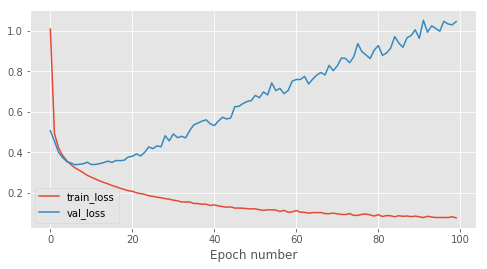

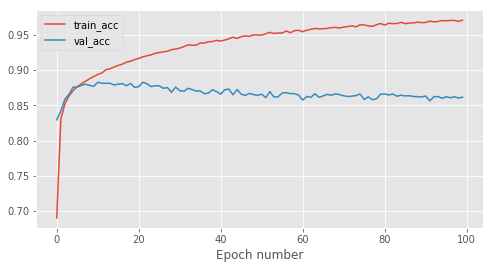

loss: 3.8520, accuracy: 0.0400:   0%|          | 3/1000 [00:00<00:19, 51.77it/s]

stride3_filter64_layer4_type3
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 10, 10])
torch.Size([100, 64, 10, 10])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=3, stride=3, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=3, stride=3, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=3, stride=3, padding=1)
    (conv_3): 

loss: 1.9287, accuracy: 0.4600:   1%|          | 12/1000 [00:00<00:15, 65.77it/s]

Epoch 0: train_acc_0.2584_train_loss_2.6019_val_acc_0.4180_val_loss_1.9179 epoch time 17.1500 seconds
total time0.0 : 17.149953603744507


loss: 1.1252, accuracy: 0.6800:   1%|          | 12/1000 [00:00<00:14, 66.58it/s]

Epoch 1: train_acc_0.5447_train_loss_1.4993_val_acc_0.6278_val_loss_1.1900 epoch time 16.9448 seconds
total time0.0 : 34.09471368789673


loss: 1.0389, accuracy: 0.6300:   1%|          | 12/1000 [00:00<00:14, 67.66it/s]

Epoch 2: train_acc_0.6810_train_loss_1.0329_val_acc_0.7166_val_loss_0.9075 epoch time 17.0197 seconds
total time0.0 : 51.114378690719604


loss: 0.6916, accuracy: 0.7400:   1%|▏         | 13/1000 [00:00<00:14, 67.19it/s]

Epoch 3: train_acc_0.7413_train_loss_0.8225_val_acc_0.7630_val_loss_0.7381 epoch time 16.9054 seconds
total time1.0 : 8.019766569137573


loss: 1.2415, accuracy: 0.7600:   1%|          | 12/1000 [00:00<00:15, 65.29it/s]

Epoch 4: train_acc_0.7695_train_loss_0.7191_val_acc_0.7707_val_loss_0.7060 epoch time 17.0171 seconds
total time1.0 : 25.036874532699585


loss: 0.5884, accuracy: 0.8200:   1%|          | 12/1000 [00:00<00:15, 64.85it/s]

Epoch 5: train_acc_0.7906_train_loss_0.6475_val_acc_0.7920_val_loss_0.6093 epoch time 17.0751 seconds
total time1.0 : 42.11194610595703


loss: 0.5225, accuracy: 0.8400:   1%|          | 12/1000 [00:00<00:14, 66.75it/s]

Epoch 6: train_acc_0.8043_train_loss_0.6000_val_acc_0.8144_val_loss_0.5644 epoch time 17.0276 seconds
total time1.0 : 59.13957071304321


loss: 0.5518, accuracy: 0.8300:   1%|          | 12/1000 [00:00<00:15, 65.47it/s]

Epoch 7: train_acc_0.8155_train_loss_0.5640_val_acc_0.8196_val_loss_0.5294 epoch time 17.0597 seconds
total time2.0 : 16.199284076690674


loss: 0.5909, accuracy: 0.8300:   1%|          | 12/1000 [00:00<00:14, 67.39it/s]

Epoch 8: train_acc_0.8203_train_loss_0.5364_val_acc_0.8325_val_loss_0.5078 epoch time 17.0477 seconds
total time2.0 : 33.24695086479187


loss: 0.3419, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 68.77it/s]

Epoch 9: train_acc_0.8285_train_loss_0.5089_val_acc_0.8315_val_loss_0.5043 epoch time 17.0843 seconds
total time2.0 : 50.33121180534363


loss: 0.4092, accuracy: 0.8600:   1%|          | 12/1000 [00:00<00:15, 64.45it/s]

Epoch 10: train_acc_0.8354_train_loss_0.4871_val_acc_0.8397_val_loss_0.4629 epoch time 16.9530 seconds
total time3.0 : 7.284191370010376


loss: 0.5544, accuracy: 0.8000:   1%|          | 12/1000 [00:00<00:15, 65.72it/s]

Epoch 11: train_acc_0.8396_train_loss_0.4678_val_acc_0.8516_val_loss_0.4362 epoch time 16.6847 seconds
total time3.0 : 23.968920946121216


loss: 0.6320, accuracy: 0.7500:   1%|          | 12/1000 [00:00<00:15, 65.45it/s]

Epoch 12: train_acc_0.8447_train_loss_0.4522_val_acc_0.8487_val_loss_0.4394 epoch time 17.1490 seconds
total time3.0 : 41.117934465408325


loss: 0.5003, accuracy: 0.8100:   1%|          | 12/1000 [00:00<00:14, 65.95it/s]

Epoch 13: train_acc_0.8487_train_loss_0.4371_val_acc_0.8534_val_loss_0.4257 epoch time 17.2083 seconds
total time3.0 : 58.32622957229614


loss: 0.4620, accuracy: 0.8300:   1%|          | 12/1000 [00:00<00:15, 64.42it/s]

Epoch 14: train_acc_0.8530_train_loss_0.4238_val_acc_0.8581_val_loss_0.4166 epoch time 17.0901 seconds
total time4.0 : 15.4162917137146


loss: 0.3526, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:15, 64.51it/s]

Epoch 15: train_acc_0.8560_train_loss_0.4115_val_acc_0.8566_val_loss_0.4135 epoch time 17.1101 seconds
total time4.0 : 32.52638483047485


loss: 0.2520, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 66.89it/s]

Epoch 16: train_acc_0.8572_train_loss_0.4031_val_acc_0.8606_val_loss_0.3956 epoch time 17.1196 seconds
total time4.0 : 49.64600110054016


loss: 0.3069, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:14, 66.64it/s]

Epoch 17: train_acc_0.8620_train_loss_0.3914_val_acc_0.8539_val_loss_0.4048 epoch time 17.0374 seconds
total time5.0 : 6.683415174484253


loss: 0.4371, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:14, 65.93it/s]

Epoch 18: train_acc_0.8639_train_loss_0.3831_val_acc_0.8699_val_loss_0.3701 epoch time 16.9719 seconds
total time5.0 : 23.655324697494507


loss: 0.4194, accuracy: 0.8200:   1%|          | 12/1000 [00:00<00:15, 65.77it/s]

Epoch 19: train_acc_0.8668_train_loss_0.3754_val_acc_0.8686_val_loss_0.3692 epoch time 16.8643 seconds
total time5.0 : 40.51957583427429


loss: 0.4082, accuracy: 0.8400:   1%|▏         | 13/1000 [00:00<00:14, 67.30it/s]

Epoch 20: train_acc_0.8690_train_loss_0.3682_val_acc_0.8686_val_loss_0.3670 epoch time 17.0202 seconds
total time5.0 : 57.539814710617065


loss: 0.3821, accuracy: 0.8500:   1%|          | 12/1000 [00:00<00:15, 65.41it/s]

Epoch 21: train_acc_0.8712_train_loss_0.3612_val_acc_0.8677_val_loss_0.3661 epoch time 17.0369 seconds
total time6.0 : 14.576747417449951


loss: 0.4194, accuracy: 0.8300:   1%|          | 12/1000 [00:00<00:14, 66.87it/s]

Epoch 22: train_acc_0.8726_train_loss_0.3560_val_acc_0.8722_val_loss_0.3596 epoch time 16.9287 seconds
total time6.0 : 31.505431413650513


loss: 0.3784, accuracy: 0.8600:   1%|          | 12/1000 [00:00<00:14, 66.25it/s]

Epoch 23: train_acc_0.8751_train_loss_0.3488_val_acc_0.8717_val_loss_0.3631 epoch time 17.0506 seconds
total time6.0 : 48.55604696273804


loss: 0.2765, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:15, 65.33it/s]

Epoch 24: train_acc_0.8763_train_loss_0.3438_val_acc_0.8681_val_loss_0.3626 epoch time 17.0316 seconds
total time7.0 : 5.587600231170654


loss: 0.3998, accuracy: 0.8300:   1%|          | 12/1000 [00:00<00:15, 64.15it/s]

Epoch 25: train_acc_0.8772_train_loss_0.3390_val_acc_0.8762_val_loss_0.3519 epoch time 17.0198 seconds
total time7.0 : 22.607433557510376


loss: 0.2292, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:14, 66.97it/s]

Epoch 26: train_acc_0.8783_train_loss_0.3340_val_acc_0.8751_val_loss_0.3498 epoch time 17.0936 seconds
total time7.0 : 39.70099854469299


loss: 0.2321, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 65.88it/s]

Epoch 27: train_acc_0.8801_train_loss_0.3286_val_acc_0.8755_val_loss_0.3509 epoch time 17.0766 seconds
total time7.0 : 56.77755904197693


loss: 0.3581, accuracy: 0.8700:   1%|          | 12/1000 [00:00<00:14, 66.16it/s]

Epoch 28: train_acc_0.8819_train_loss_0.3249_val_acc_0.8791_val_loss_0.3354 epoch time 17.0684 seconds
total time8.0 : 13.845979928970337


loss: 0.3181, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:15, 65.79it/s]

Epoch 29: train_acc_0.8826_train_loss_0.3208_val_acc_0.8797_val_loss_0.3305 epoch time 16.5909 seconds
total time8.0 : 30.436874389648438


loss: 0.3088, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:15, 65.59it/s]

Epoch 30: train_acc_0.8843_train_loss_0.3152_val_acc_0.8753_val_loss_0.3488 epoch time 17.0829 seconds
total time8.0 : 47.51972460746765


loss: 0.2554, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:14, 66.87it/s]

Epoch 31: train_acc_0.8866_train_loss_0.3125_val_acc_0.8798_val_loss_0.3363 epoch time 17.0049 seconds
total time9.0 : 4.524609088897705


loss: 0.2515, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:14, 66.30it/s]

Epoch 32: train_acc_0.8860_train_loss_0.3089_val_acc_0.8820_val_loss_0.3323 epoch time 17.0433 seconds
total time9.0 : 21.56789755821228


loss: 0.3296, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:15, 65.77it/s]

Epoch 33: train_acc_0.8886_train_loss_0.3048_val_acc_0.8757_val_loss_0.3397 epoch time 17.1415 seconds
total time9.0 : 38.70939660072327


loss: 0.2904, accuracy: 0.8700:   1%|          | 12/1000 [00:00<00:15, 65.85it/s]

Epoch 34: train_acc_0.8891_train_loss_0.3017_val_acc_0.8773_val_loss_0.3388 epoch time 17.0306 seconds
total time9.0 : 55.739954710006714


loss: 0.3830, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 67.93it/s]

Epoch 35: train_acc_0.8906_train_loss_0.2979_val_acc_0.8841_val_loss_0.3250 epoch time 17.0821 seconds
total time10.0 : 12.82204270362854


loss: 0.2917, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 65.74it/s]

Epoch 36: train_acc_0.8909_train_loss_0.2946_val_acc_0.8809_val_loss_0.3262 epoch time 17.0750 seconds
total time10.0 : 29.897082090377808


loss: 0.4002, accuracy: 0.8700:   1%|          | 12/1000 [00:00<00:15, 64.96it/s]

Epoch 37: train_acc_0.8914_train_loss_0.2928_val_acc_0.8847_val_loss_0.3249 epoch time 16.8325 seconds
total time10.0 : 46.72954773902893


loss: 0.2598, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:14, 67.18it/s]

Epoch 38: train_acc_0.8918_train_loss_0.2896_val_acc_0.8818_val_loss_0.3254 epoch time 17.0148 seconds
total time11.0 : 3.744389772415161


loss: 0.3577, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 64.45it/s]

Epoch 39: train_acc_0.8925_train_loss_0.2870_val_acc_0.8753_val_loss_0.3369 epoch time 17.0530 seconds
total time11.0 : 20.79738759994507


loss: 0.3562, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 65.16it/s]

Epoch 40: train_acc_0.8933_train_loss_0.2833_val_acc_0.8846_val_loss_0.3189 epoch time 17.0298 seconds
total time11.0 : 37.827167987823486


loss: 0.3535, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 65.10it/s]

Epoch 41: train_acc_0.8950_train_loss_0.2797_val_acc_0.8849_val_loss_0.3212 epoch time 17.1292 seconds
total time11.0 : 54.9563410282135


loss: 0.3284, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 66.59it/s]

Epoch 42: train_acc_0.8965_train_loss_0.2769_val_acc_0.8815_val_loss_0.3239 epoch time 17.0894 seconds
total time12.0 : 12.045734643936157


loss: 0.2209, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:15, 65.79it/s]

Epoch 43: train_acc_0.8967_train_loss_0.2769_val_acc_0.8846_val_loss_0.3192 epoch time 16.9618 seconds
total time12.0 : 29.00756025314331


loss: 0.2822, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:15, 65.30it/s]

Epoch 44: train_acc_0.8962_train_loss_0.2738_val_acc_0.8834_val_loss_0.3283 epoch time 17.1127 seconds
total time12.0 : 46.12023377418518


loss: 0.4108, accuracy: 0.8500:   1%|          | 12/1000 [00:00<00:14, 66.69it/s]

Epoch 45: train_acc_0.8980_train_loss_0.2706_val_acc_0.8869_val_loss_0.3245 epoch time 17.1143 seconds
total time13.0 : 3.2345707416534424


loss: 0.3337, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 67.95it/s]

Epoch 46: train_acc_0.8994_train_loss_0.2675_val_acc_0.8820_val_loss_0.3274 epoch time 17.1282 seconds
total time13.0 : 20.36277174949646


loss: 0.2270, accuracy: 0.9200:   1%|▏         | 13/1000 [00:00<00:14, 69.84it/s]

Epoch 47: train_acc_0.8986_train_loss_0.2673_val_acc_0.8832_val_loss_0.3242 epoch time 16.8137 seconds
total time13.0 : 37.17644929885864


loss: 0.2050, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 66.35it/s]

Epoch 48: train_acc_0.9003_train_loss_0.2648_val_acc_0.8837_val_loss_0.3357 epoch time 16.9846 seconds
total time13.0 : 54.1610164642334


loss: 0.3153, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 64.15it/s]

Epoch 49: train_acc_0.9009_train_loss_0.2617_val_acc_0.8853_val_loss_0.3244 epoch time 17.1433 seconds
total time14.0 : 11.304309129714966


loss: 0.1635, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:14, 67.07it/s]

Epoch 50: train_acc_0.9017_train_loss_0.2596_val_acc_0.8863_val_loss_0.3208 epoch time 17.1474 seconds
total time14.0 : 28.451736211776733


loss: 0.2156, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:14, 66.88it/s]

Epoch 51: train_acc_0.9021_train_loss_0.2578_val_acc_0.8859_val_loss_0.3216 epoch time 17.1466 seconds
total time14.0 : 45.59837007522583


loss: 0.2691, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:14, 66.38it/s]

Epoch 52: train_acc_0.9015_train_loss_0.2567_val_acc_0.8843_val_loss_0.3271 epoch time 17.0522 seconds
total time15.0 : 2.650526285171509


loss: 0.3194, accuracy: 0.8500:   1%|          | 12/1000 [00:00<00:14, 66.03it/s]

Epoch 53: train_acc_0.9039_train_loss_0.2533_val_acc_0.8875_val_loss_0.3200 epoch time 17.0978 seconds
total time15.0 : 19.748353004455566


loss: 0.2424, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:15, 65.42it/s]

Epoch 54: train_acc_0.9037_train_loss_0.2522_val_acc_0.8820_val_loss_0.3257 epoch time 17.1001 seconds
total time15.0 : 36.84850287437439


loss: 0.2122, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:15, 63.79it/s]

Epoch 55: train_acc_0.9040_train_loss_0.2498_val_acc_0.8820_val_loss_0.3267 epoch time 16.8401 seconds
total time15.0 : 53.68862533569336


loss: 0.2930, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 64.94it/s]

Epoch 56: train_acc_0.9045_train_loss_0.2479_val_acc_0.8840_val_loss_0.3273 epoch time 17.1546 seconds
total time16.0 : 10.843267440795898


loss: 0.2758, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 65.77it/s]

Epoch 57: train_acc_0.9057_train_loss_0.2469_val_acc_0.8856_val_loss_0.3258 epoch time 17.0815 seconds
total time16.0 : 27.924769639968872


loss: 0.2746, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:15, 65.01it/s]

Epoch 58: train_acc_0.9066_train_loss_0.2441_val_acc_0.8827_val_loss_0.3288 epoch time 17.0183 seconds
total time16.0 : 44.9430787563324


loss: 0.3965, accuracy: 0.8600:   1%|          | 12/1000 [00:00<00:14, 66.75it/s]

Epoch 59: train_acc_0.9063_train_loss_0.2429_val_acc_0.8858_val_loss_0.3202 epoch time 16.9743 seconds
total time17.0 : 1.917421817779541


loss: 0.2094, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:15, 65.41it/s]

Epoch 60: train_acc_0.9065_train_loss_0.2406_val_acc_0.8832_val_loss_0.3272 epoch time 16.9117 seconds
total time17.0 : 18.82912588119507


loss: 0.2968, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:14, 66.38it/s]

Epoch 61: train_acc_0.9075_train_loss_0.2390_val_acc_0.8877_val_loss_0.3220 epoch time 16.9306 seconds
total time17.0 : 35.75973558425903


loss: 0.2771, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:15, 65.45it/s]

Epoch 62: train_acc_0.9077_train_loss_0.2380_val_acc_0.8826_val_loss_0.3337 epoch time 17.0864 seconds
total time17.0 : 52.846123695373535


loss: 0.1221, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 66.17it/s]

Epoch 63: train_acc_0.9088_train_loss_0.2366_val_acc_0.8884_val_loss_0.3232 epoch time 17.0243 seconds
total time18.0 : 9.870439291000366


loss: 0.1649, accuracy: 0.9500:   1%|          | 12/1000 [00:00<00:15, 64.79it/s]

Epoch 64: train_acc_0.9090_train_loss_0.2345_val_acc_0.8802_val_loss_0.3382 epoch time 16.9577 seconds
total time18.0 : 26.828168392181396


loss: 0.1463, accuracy: 0.9300:   1%|▏         | 13/1000 [00:00<00:14, 69.53it/s]

Epoch 65: train_acc_0.9089_train_loss_0.2331_val_acc_0.8865_val_loss_0.3202 epoch time 16.9297 seconds
total time18.0 : 43.757872343063354


loss: 0.1465, accuracy: 0.9500:   1%|▏         | 13/1000 [00:00<00:14, 68.99it/s]

Epoch 66: train_acc_0.9097_train_loss_0.2308_val_acc_0.8838_val_loss_0.3311 epoch time 16.6701 seconds
total time19.0 : 0.4280059337615967


loss: 0.3434, accuracy: 0.8400:   1%|          | 12/1000 [00:00<00:14, 66.17it/s]

Epoch 67: train_acc_0.9110_train_loss_0.2285_val_acc_0.8865_val_loss_0.3332 epoch time 17.0013 seconds
total time19.0 : 17.429258108139038


loss: 0.1183, accuracy: 0.9700:   1%|          | 12/1000 [00:00<00:14, 67.19it/s]

Epoch 68: train_acc_0.9109_train_loss_0.2286_val_acc_0.8858_val_loss_0.3305 epoch time 17.0271 seconds
total time19.0 : 34.45635461807251


loss: 0.2504, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 67.97it/s]

Epoch 69: train_acc_0.9111_train_loss_0.2266_val_acc_0.8854_val_loss_0.3263 epoch time 17.1294 seconds
total time19.0 : 51.5857195854187


loss: 0.1898, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:14, 68.43it/s]

Epoch 70: train_acc_0.9116_train_loss_0.2257_val_acc_0.8844_val_loss_0.3298 epoch time 17.0771 seconds
total time20.0 : 8.66282844543457


loss: 0.2138, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:15, 65.71it/s]

Epoch 71: train_acc_0.9123_train_loss_0.2233_val_acc_0.8838_val_loss_0.3299 epoch time 17.0281 seconds
total time20.0 : 25.6909122467041


loss: 0.2642, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:15, 65.55it/s]

Epoch 72: train_acc_0.9125_train_loss_0.2232_val_acc_0.8822_val_loss_0.3329 epoch time 16.8970 seconds
total time20.0 : 42.58786940574646


loss: 0.2124, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:14, 66.76it/s]

Epoch 73: train_acc_0.9131_train_loss_0.2203_val_acc_0.8829_val_loss_0.3452 epoch time 16.7763 seconds
total time20.0 : 59.36412787437439


loss: 0.1908, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:14, 67.28it/s]

Epoch 74: train_acc_0.9135_train_loss_0.2200_val_acc_0.8808_val_loss_0.3381 epoch time 16.8288 seconds
total time21.0 : 16.192970752716064


loss: 0.2878, accuracy: 0.8700:   1%|          | 12/1000 [00:00<00:14, 66.18it/s]

Epoch 75: train_acc_0.9138_train_loss_0.2184_val_acc_0.8831_val_loss_0.3353 epoch time 16.9123 seconds
total time21.0 : 33.105262756347656


loss: 0.2318, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:14, 66.26it/s]

Epoch 76: train_acc_0.9147_train_loss_0.2171_val_acc_0.8861_val_loss_0.3321 epoch time 17.0151 seconds
total time21.0 : 50.12033152580261


loss: 0.2170, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:14, 66.75it/s]

Epoch 77: train_acc_0.9150_train_loss_0.2159_val_acc_0.8870_val_loss_0.3329 epoch time 17.0053 seconds
total time22.0 : 7.125652313232422


loss: 0.2118, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:14, 68.64it/s]

Epoch 78: train_acc_0.9150_train_loss_0.2147_val_acc_0.8863_val_loss_0.3335 epoch time 16.8951 seconds
total time22.0 : 24.020713090896606


loss: 0.2249, accuracy: 0.8700:   1%|▏         | 13/1000 [00:00<00:14, 68.61it/s]

Epoch 79: train_acc_0.9149_train_loss_0.2137_val_acc_0.8846_val_loss_0.3448 epoch time 17.1364 seconds
total time22.0 : 41.15707993507385


loss: 0.1605, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:14, 66.10it/s]

Epoch 80: train_acc_0.9153_train_loss_0.2117_val_acc_0.8801_val_loss_0.3430 epoch time 17.1077 seconds
total time22.0 : 58.264769315719604


loss: 0.1665, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:15, 64.94it/s]

Epoch 81: train_acc_0.9152_train_loss_0.2120_val_acc_0.8835_val_loss_0.3425 epoch time 17.1144 seconds
total time23.0 : 15.379212617874146


loss: 0.1330, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:15, 65.09it/s]

Epoch 82: train_acc_0.9165_train_loss_0.2099_val_acc_0.8790_val_loss_0.3451 epoch time 17.0478 seconds
total time23.0 : 32.42705154418945


loss: 0.2634, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 67.37it/s]

Epoch 83: train_acc_0.9161_train_loss_0.2094_val_acc_0.8840_val_loss_0.3426 epoch time 17.1814 seconds
total time23.0 : 49.608481645584106


loss: 0.1629, accuracy: 0.9300:   1%|          | 12/1000 [00:00<00:14, 66.31it/s]

Epoch 84: train_acc_0.9167_train_loss_0.2079_val_acc_0.8861_val_loss_0.3410 epoch time 16.7026 seconds
total time24.0 : 6.311119079589844


loss: 0.1699, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 65.99it/s]

Epoch 85: train_acc_0.9166_train_loss_0.2064_val_acc_0.8816_val_loss_0.3441 epoch time 16.9057 seconds
total time24.0 : 23.21686553955078


loss: 0.2658, accuracy: 0.8800:   1%|          | 12/1000 [00:00<00:15, 65.62it/s]

Epoch 86: train_acc_0.9178_train_loss_0.2040_val_acc_0.8828_val_loss_0.3484 epoch time 16.9505 seconds
total time24.0 : 40.16731858253479


loss: 0.3507, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:15, 65.39it/s]

Epoch 87: train_acc_0.9183_train_loss_0.2038_val_acc_0.8819_val_loss_0.3462 epoch time 17.0454 seconds
total time24.0 : 57.21273136138916


loss: 0.1330, accuracy: 0.9600:   1%|          | 12/1000 [00:00<00:14, 66.80it/s]

Epoch 88: train_acc_0.9189_train_loss_0.2018_val_acc_0.8806_val_loss_0.3542 epoch time 16.8483 seconds
total time25.0 : 14.061074256896973


loss: 0.3086, accuracy: 0.9000:   1%|          | 12/1000 [00:00<00:14, 66.80it/s]

Epoch 89: train_acc_0.9188_train_loss_0.2010_val_acc_0.8846_val_loss_0.3412 epoch time 16.8860 seconds
total time25.0 : 30.947047233581543


loss: 0.1751, accuracy: 0.8900:   1%|▏         | 13/1000 [00:00<00:14, 68.01it/s]

Epoch 90: train_acc_0.9192_train_loss_0.2002_val_acc_0.8825_val_loss_0.3506 epoch time 17.1889 seconds
total time25.0 : 48.135987997055054


loss: 0.1323, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:15, 64.77it/s]

Epoch 91: train_acc_0.9186_train_loss_0.2011_val_acc_0.8749_val_loss_0.3613 epoch time 17.0287 seconds
total time26.0 : 5.164640188217163


loss: 0.2294, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 67.35it/s]

Epoch 92: train_acc_0.9207_train_loss_0.1976_val_acc_0.8829_val_loss_0.3509 epoch time 17.1123 seconds
total time26.0 : 22.276913166046143


loss: 0.2881, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:15, 64.18it/s]

Epoch 93: train_acc_0.9211_train_loss_0.1973_val_acc_0.8851_val_loss_0.3511 epoch time 17.1824 seconds
total time26.0 : 39.45932173728943


loss: 0.1655, accuracy: 0.9400:   1%|          | 12/1000 [00:00<00:15, 65.69it/s]

Epoch 94: train_acc_0.9208_train_loss_0.1959_val_acc_0.8844_val_loss_0.3489 epoch time 17.1028 seconds
total time26.0 : 56.56209397315979


loss: 0.2511, accuracy: 0.9100:   1%|          | 12/1000 [00:00<00:14, 67.91it/s]

Epoch 95: train_acc_0.9208_train_loss_0.1948_val_acc_0.8794_val_loss_0.3548 epoch time 17.0583 seconds
total time27.0 : 13.620404481887817


loss: 0.2283, accuracy: 0.8900:   1%|▏         | 13/1000 [00:00<00:14, 67.06it/s]

Epoch 96: train_acc_0.9213_train_loss_0.1939_val_acc_0.8846_val_loss_0.3524 epoch time 17.0771 seconds
total time27.0 : 30.6974618434906


loss: 0.1996, accuracy: 0.9200:   1%|          | 12/1000 [00:00<00:14, 66.50it/s]

Epoch 97: train_acc_0.9220_train_loss_0.1923_val_acc_0.8823_val_loss_0.3569 epoch time 17.1728 seconds
total time27.0 : 47.870251178741455


loss: 0.2051, accuracy: 0.8900:   1%|          | 12/1000 [00:00<00:14, 66.02it/s]

Epoch 98: train_acc_0.9228_train_loss_0.1913_val_acc_0.8810_val_loss_0.3550 epoch time 17.0078 seconds
total time28.0 : 4.878086805343628


loss: 0.3414, accuracy: 0.9000:  16%|█▌        | 25/158 [00:00<00:00, 137.26it/s]

Epoch 99: train_acc_0.9227_train_loss_0.1910_val_acc_0.8829_val_loss_0.3577 epoch time 17.0996 seconds
total time28.0 : 21.977638244628906
Generating test set evaluation metrics


loss: 0.3528, accuracy: 0.8700: 100%|██████████| 158/158 [00:01<00:00, 118.49it/s]


finish


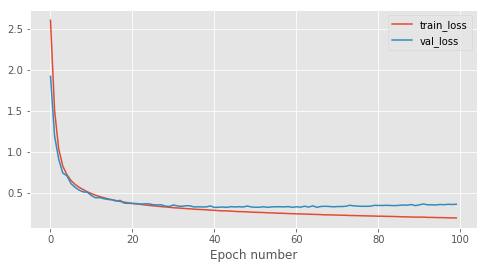

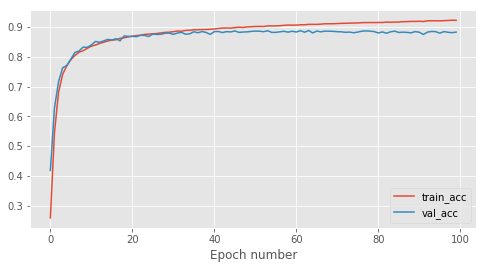

In [6]:
#stride3_filter64_layer4_type01234

batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [2,3]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [4,4,4,4]
experiment_name = []
for layer,index in zip(num_layers,dim_reduction_idx):
    experiment_name.append("stride3_filter64_layer{}_type{}".format(layer,index))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for experiment,layer,index in zip(experiment_name,num_layers,dim_reduction_idx):
    
    print(experiment)
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[index],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])